<a href="https://colab.research.google.com/github/Ashibong/Capstone-Design-DHKim-/blob/main/R1_based_Balancing_Index_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 파라미터별 변화량.xlsx to 파라미터별 변화량 (3).xlsx


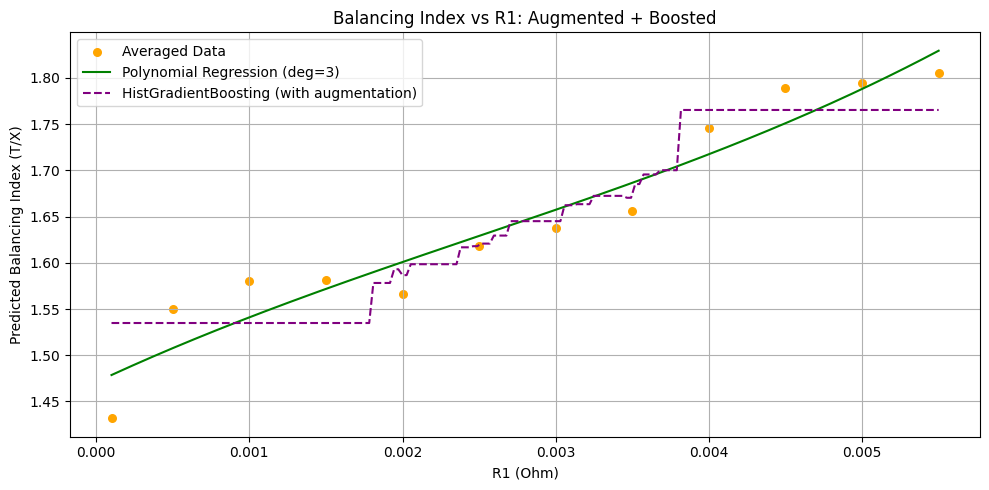

In [ ]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from google.colab import files

# 2. 엑셀 파일 업로드
uploaded = files.upload()

# 3. 데이터 불러오기
df = pd.read_excel("파라미터별 변화량.xlsx", sheet_name="Sheet2")

# 4. R1과 T/X만 사용
df['T/X'] = pd.to_numeric(df['T/X'], errors='coerce')
df_r1 = df[['R1', 'T/X']].dropna() # R1과 T/X 열만 추출
df_r1_avg = df_r1.groupby('R1', as_index=False).mean()

# 5. 다항 회귀 모델 (기준 모델)
X_avg = df_r1_avg[['R1']].values
y_avg = df_r1_avg['T/X'].values
degree = 3 # 다항 회귀에 사용되는 차수

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # 데이터를 다항 특성으로 변환 x->[1,x,x^2,x^3] 변환 후 선형회귀 수행
poly_model.fit(X_avg, y_avg)

# 6. 의사 데이터 생성 (다항 회귀 곡선 기반 + 가우시안 노이즈)
synthetic_X = np.linspace(X_avg.min(), X_avg.max(), 50).reshape(-1, 1) # R1 값 구간을 50개로 분할하여 의사 입력값 생성
synthetic_y = poly_model.predict(synthetic_X) + np.random.normal(0, 0.01, size=synthetic_X.shape[0]) # (0,0.01)인 가우시안 노이즈 추가

# 7. 증강된 데이터 결합
X_aug = np.vstack([X_avg, synthetic_X])
y_aug = np.concatenate([y_avg, synthetic_y])

# 8. Boosting 모델 학습
boost_model = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, random_state=42)
boost_model.fit(X_aug, y_aug) # 모델 학습 수행

# 9. 예측 및 시각화
r1_range = np.linspace(X_avg.min(), X_avg.max(), 200).reshape(-1, 1)
y_poly_pred = poly_model.predict(r1_range) # 다항 회귀 모델 예측
y_boost_pred = boost_model.predict(r1_range) # Boosting 모델로 예측 수행

plt.figure(figsize=(10, 5))
plt.scatter(X_avg, y_avg, color='orange', s=30, label='Averaged Data') # 주황색 점들로 원래 데이터에서 R1값 기반의 Balancing Index
plt.plot(r1_range, y_poly_pred, color='green', label='Polynomial Regression (deg=3)') # 초록색 실선은 다항 회귀모델 기반 예측
plt.plot(r1_range, y_boost_pred, color='purple', linestyle='--', label='HistGradientBoosting (with augmentation)') # 보라색 점선은 증강이 들어간 Boosting model 예측 결과
plt.xlabel("R1 (Ohm)")
plt.ylabel("Predicted Balancing Index (T/X)")
plt.title("Balancing Index vs R1: Augmented + Boosted")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 10. 단순 추정 그래프 시각화
plt.figure(figsize=(8, 4))
plt.plot(r1_range, predicted_index, marker='o', linestyle='-', color='blue')
plt.xlabel("R1 (Ohm)")
plt.ylabel("Predicted Balancing Index")
plt.title("Predicted Balancing Index vs R1 (≤ 0.005 Ohm)")
plt.grid(True)
plt.tight_layout()
plt.show()

results = pd.DataFrame({
    'R1 (Ohm)': r1_range.flatten(),
    'Predicted Index': predicted_index
})
results.head()

NameError: name 'predicted_index' is not defined

<Figure size 800x400 with 0 Axes>

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 예측값 (기존 데이터에 대해 평가)
y_poly_pred_eval = poly_model.predict(X_avg)
y_boost_pred_eval = boost_model.predict(X_avg)

# 다항 회귀 평가
r2_poly = r2_score(y_avg, y_poly_pred_eval) # R^2 결정계수
mae_poly = mean_absolute_error(y_avg, y_poly_pred_eval) # MAE: 예측값과 실제값 차이의 평균 절댓값
rmse_poly = np.sqrt(mean_squared_error(y_avg, y_poly_pred_eval)) # RMSE: 평균 제곱 오차의 제곱근

# Boosting 평가
r2_boost = r2_score(y_avg, y_boost_pred_eval)
mae_boost = mean_absolute_error(y_avg, y_boost_pred_eval)
rmse_boost = np.sqrt(mean_squared_error(y_avg, y_boost_pred_eval))

# 결과 출력
print(" Polynomial Regression (degree=3)")
print(f"R²     : {r2_poly:.4f}")
print(f"MAE    : {mae_poly:.4f}")
print(f"RMSE   : {rmse_poly:.4f}")
print()

print(" HistGradientBoosting Regressor (with augmentation)")
print(f"R²     : {r2_boost:.4f}")
print(f"MAE    : {mae_boost:.4f}")
print(f"RMSE   : {rmse_boost:.4f}")


 Polynomial Regression (degree=3)
R²     : 0.9252
MAE    : 0.0275
RMSE   : 0.0305

 HistGradientBoosting Regressor (with augmentation)
R²     : 0.8708
MAE    : 0.0305
RMSE   : 0.0400


In [ ]:
# 1. 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from google.colab import files

# 2. 엑셀 업로드
uploaded = files.upload()
df = pd.read_excel("파라미터별 변화량.xlsx", sheet_name="Sheet2")

# 3. 데이터 전처리
X = df[['R1', 'R2', 'R3', 'C1', 'C2', 'C3']]
y = pd.to_numeric(df['T/X'], errors='coerce')
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data['T/X']

# 4. Random Forest 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_clean, y_clean)

# 5. 중요도 추출
importances = model.feature_importances_
feature_names = X_clean.columns
importance_df = pd.DataFrame({
    'Parameter': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)  # 수평 막대차트를 위해 오름차순 정렬

# 6. 바 차트 시각화
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Parameter'], importance_df['Importance'],
         color=['#E69F00', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9', '#009E73'])
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
